## Integrated object --- all stroma

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
#import loompy
import matplotlib as mpl

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()

In [3]:
input_file = '/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/Stroma_integration_raw_no_nan.h5ad'
adata = sc.read_h5ad(input_file)

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
#sc.pp.filter_genes(adata, min_cells=3)
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

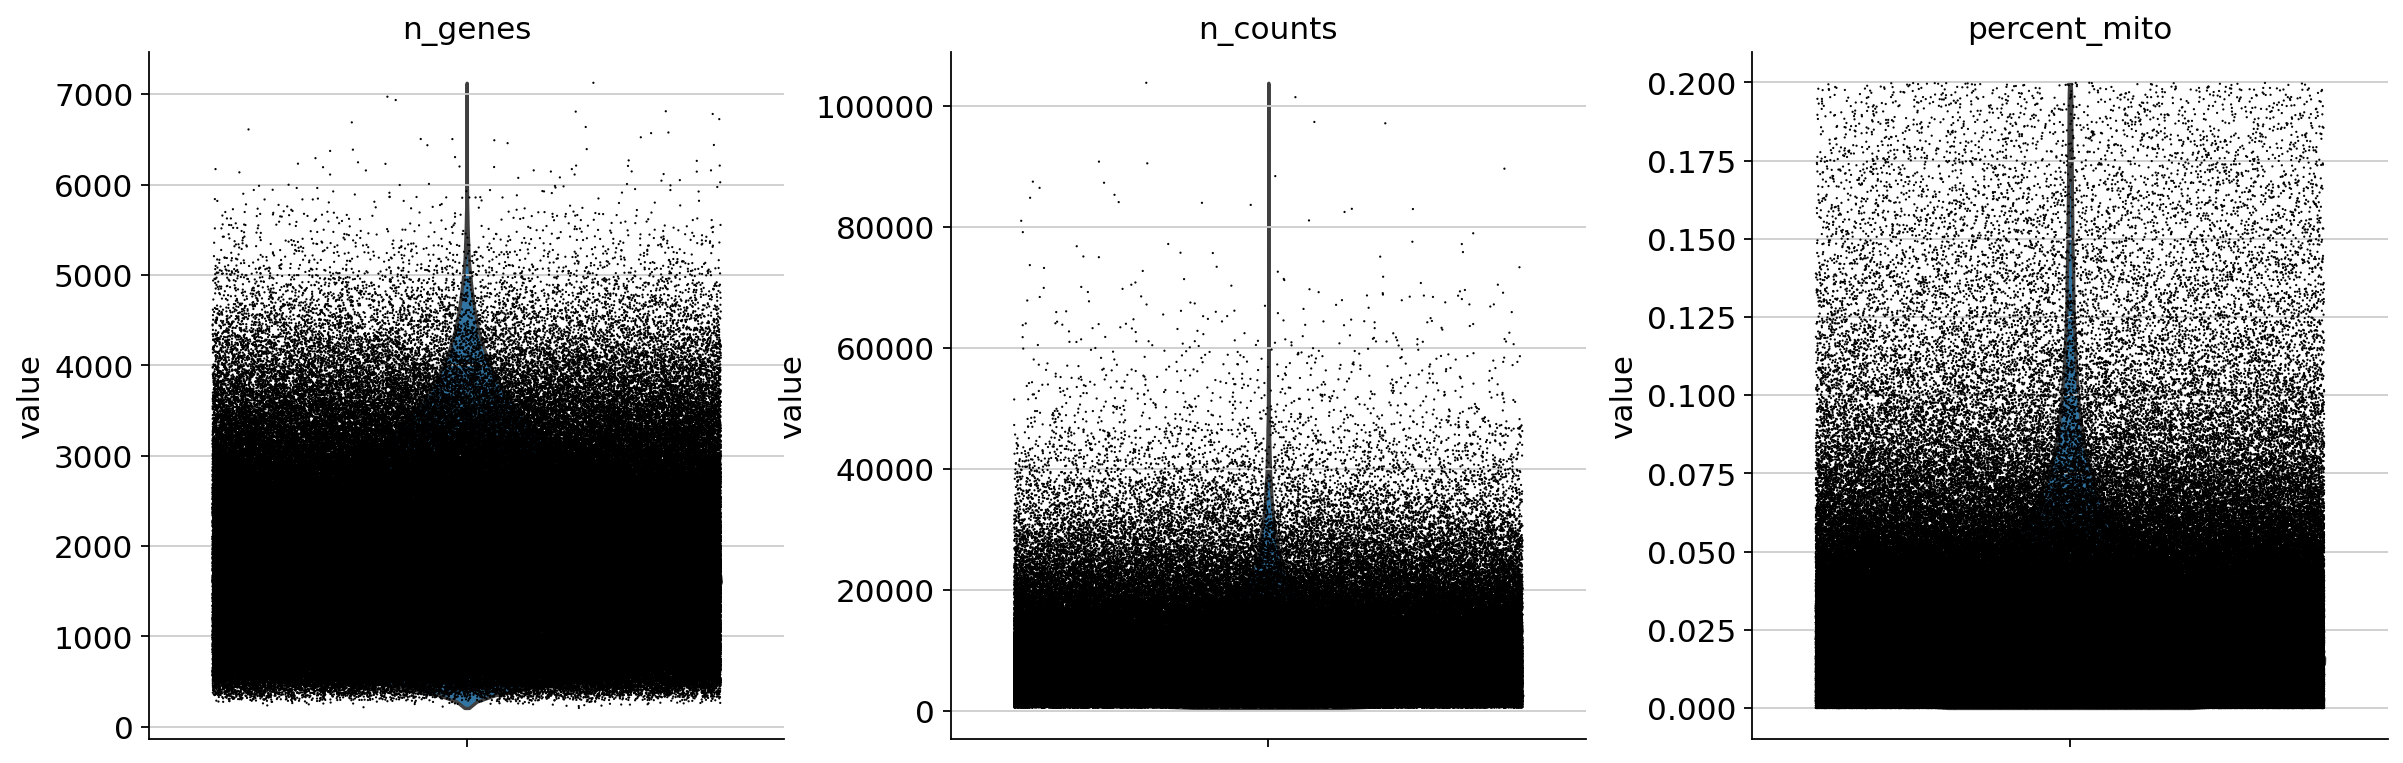

In [5]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [6]:
#adata_backup_raw = adata.copy()
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing by total count per cell
    finished (0:00:10): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:20)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


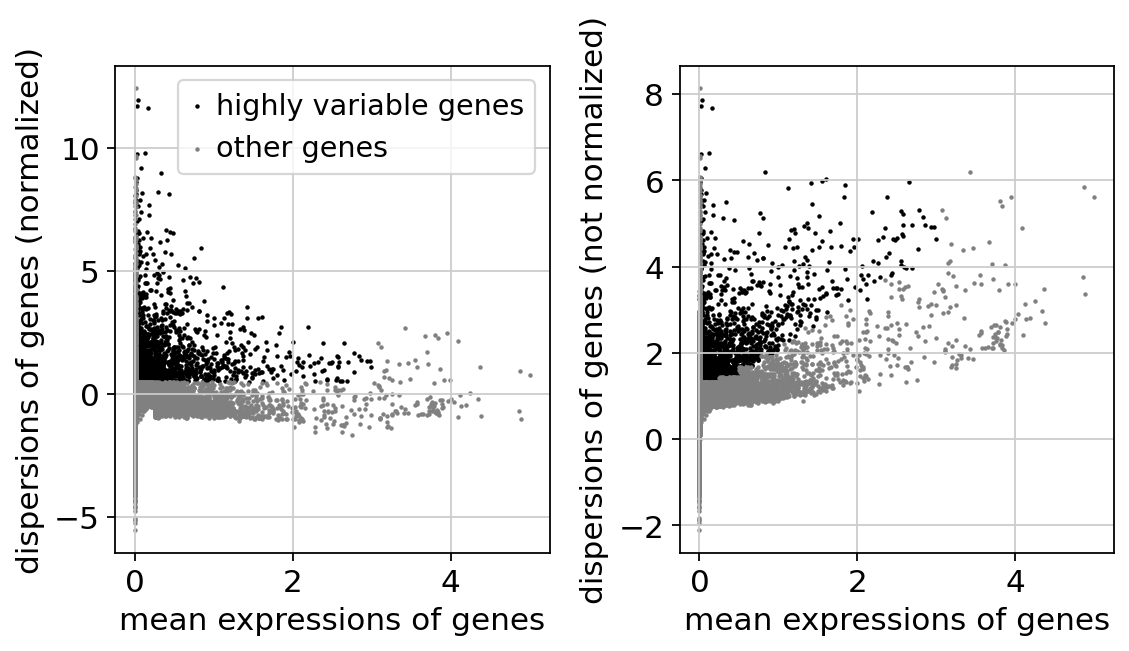

In [7]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [8]:
adata_filtered = adata[:, adata.var['highly_variable']]

In [9]:
sc.pp.regress_out(adata_filtered, ['percent_mito']) ### slow

regressing out ['percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:22:32)


In [10]:
sc.pp.scale(adata_filtered, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:48)


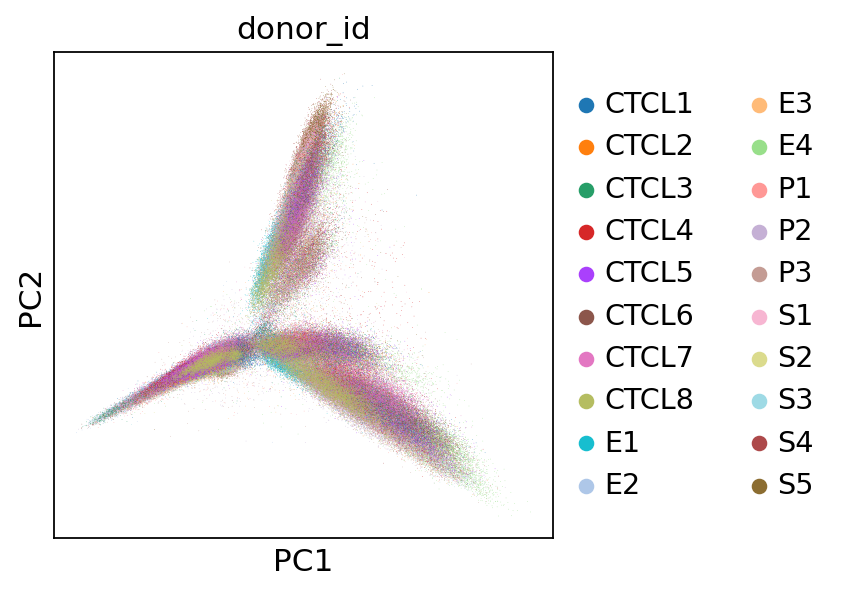

In [11]:
sc.tl.pca(adata_filtered, n_comps=50)
sc.pl.pca(adata_filtered, color = ['donor_id'])

### harmony

In [12]:
import harmonypy as hm

In [13]:
adata_filtered_harmony = adata_filtered.copy()

In [14]:
#Set harmony variables
pca = np.array(adata_filtered_harmony.obsm["X_pca"])
batch = adata_filtered_harmony.obs['donor_id']
meta_data = adata_filtered_harmony.obs

#Run Harmony
ho = hm.run_harmony(pca, meta_data, ['donor_id'], theta = 3, random_state = 1234)
res = (pd.DataFrame(ho.Z_corr)).T
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

#Insert coordinates back into object
adata_filtered_harmony.obsm["X_pca_back"]= adata_filtered_harmony.obsm["X_pca"][:]
adata_filtered_harmony.obsm["X_pca"] = np.array(res)

2021-11-17 10:56:02,039 - harmonypy - INFO - Iteration 1 of 10
2021-11-17 11:03:32,744 - harmonypy - INFO - Iteration 2 of 10
2021-11-17 11:11:02,583 - harmonypy - INFO - Iteration 3 of 10
2021-11-17 11:18:27,661 - harmonypy - INFO - Iteration 4 of 10
2021-11-17 11:25:55,850 - harmonypy - INFO - Iteration 5 of 10
2021-11-17 11:30:19,161 - harmonypy - INFO - Iteration 6 of 10
2021-11-17 11:33:19,357 - harmonypy - INFO - Iteration 7 of 10
2021-11-17 11:36:42,159 - harmonypy - INFO - Converged after 7 iterations


In [15]:
sc.pp.neighbors(adata_filtered_harmony, n_neighbors=15, n_pcs=50, random_state = 1234)
sc.tl.umap(adata_filtered_harmony)

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-c

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:03:56)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:07:58)


In [21]:
sc.tl.leiden(adata_filtered_harmony, resolution=2.0, key_added='leiden_2.0')

running Leiden clustering
    finished: found 49 clusters and added
    'leiden_2.0', the cluster labels (adata.obs, categorical) (0:09:32)


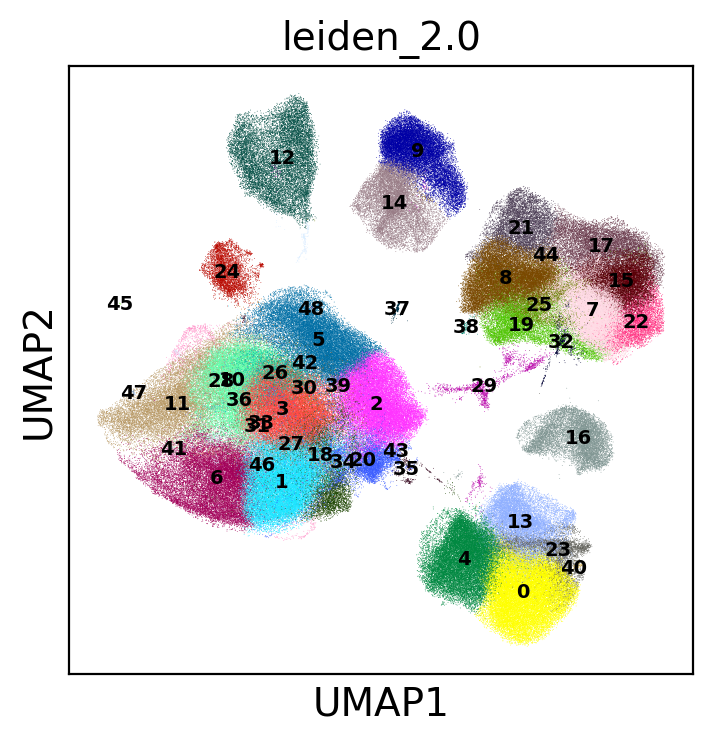

In [6]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['leiden_2.0'],legend_loc='on data', legend_fontsize=7)

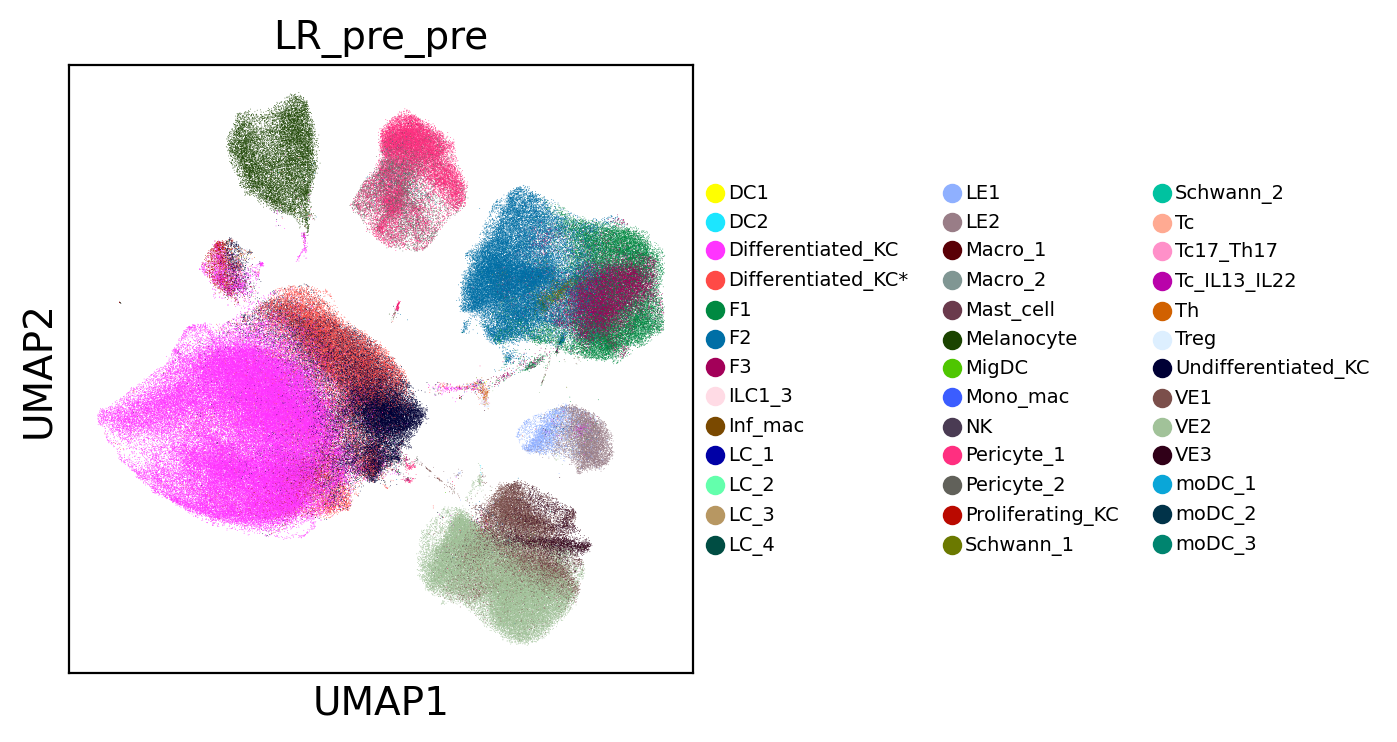

In [10]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['LR_pre_pre'], legend_fontsize=7) ## LR predictions

In [37]:
sc.tl.leiden(adata_filtered_harmony, resolution=0.2, key_added='leiden_res_0.2', restrict_to = ('leiden_2.0', ['16']))
sc.tl.leiden(adata_filtered_harmony, resolution=0.2, key_added='leiden_res_0.2', restrict_to = ('leiden_res_0.2', ['14']))
sc.tl.leiden(adata_filtered_harmony, resolution=0.2, key_added='leiden_res_0.2', restrict_to = ('leiden_res_0.2', ['25']))
sc.tl.leiden(adata_filtered_harmony, resolution=0.2, key_added='leiden_res_0.2', restrict_to = ('leiden_res_0.2', ['2']))

running Leiden clustering
    finished: found 51 clusters and added
    'leiden_res_0.2', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 53 clusters and added
    'leiden_res_0.2', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 56 clusters and added
    'leiden_res_0.2', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 56 clusters and added
    'leiden_res_0.2', the cluster labels (adata.obs, categorical) (0:00:01)


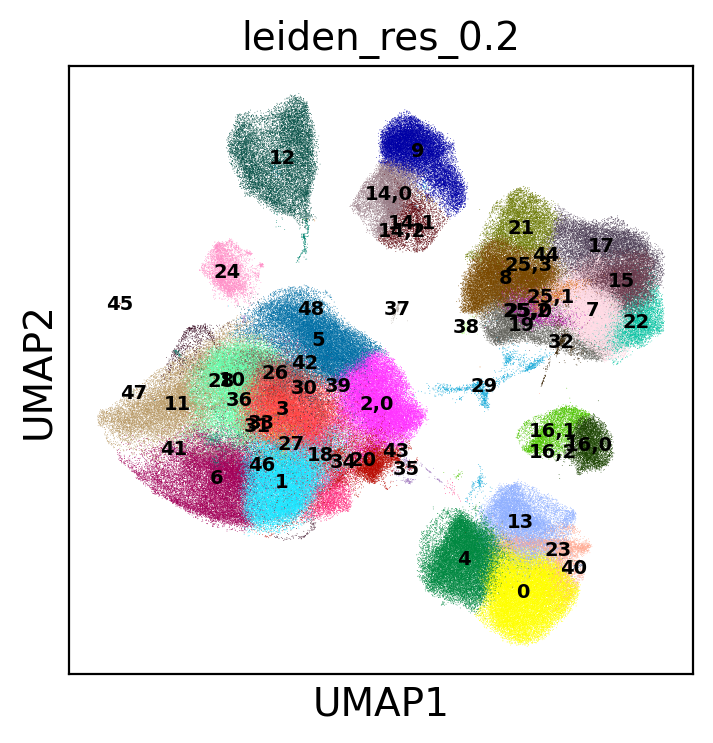

In [7]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['leiden_res_0.2'],legend_loc='on data', legend_fontsize=7)

In [19]:
nn = adata_filtered_harmony.obs['leiden_res_0.2'].unique().tolist()

In [21]:
### Annotate each cluster based on LR majority prediction
adata_filtered_harmony[adata_filtered_harmony.obs['leiden_res_0.2']=='0'].obs.LR_pre_pre.value_counts()
adata_filtered_harmony.obs.loc[adata_filtered_harmony.obs['leiden_res_0.2']=='0', 'annotation'] = "VE2"

VE2                    20348
VE1                     5791
VE3                      139
Differentiated_KC*         8
LE2                        6
F2                         5
Differentiated_KC          4
Undifferentiated_KC        2
F3                         1
Pericyte_1                 1
Name: LR_pre_pre, dtype: int64

In [22]:
adata_filtered_harmony_sub = adata_filtered_harmony[~adata_filtered_harmony.obs['leiden_res_0.2'].isin(['45','29','37','35'])]

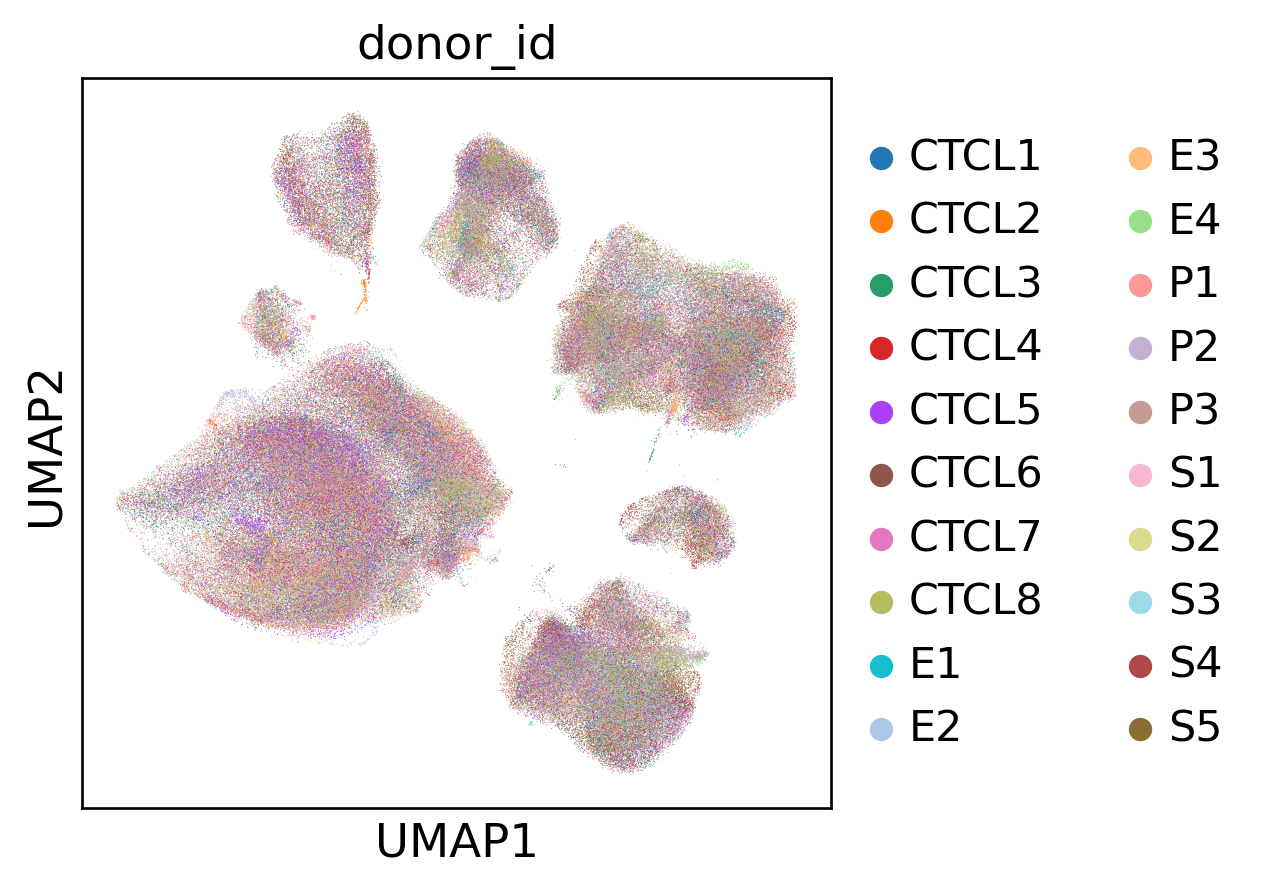

In [18]:
sc.settings.set_figure_params(dpi=120, facecolor='white')
sc.pl.umap(adata_filtered_harmony_sub, color=['donor_id'])

Trying to set attribute `.uns` of view, copying.


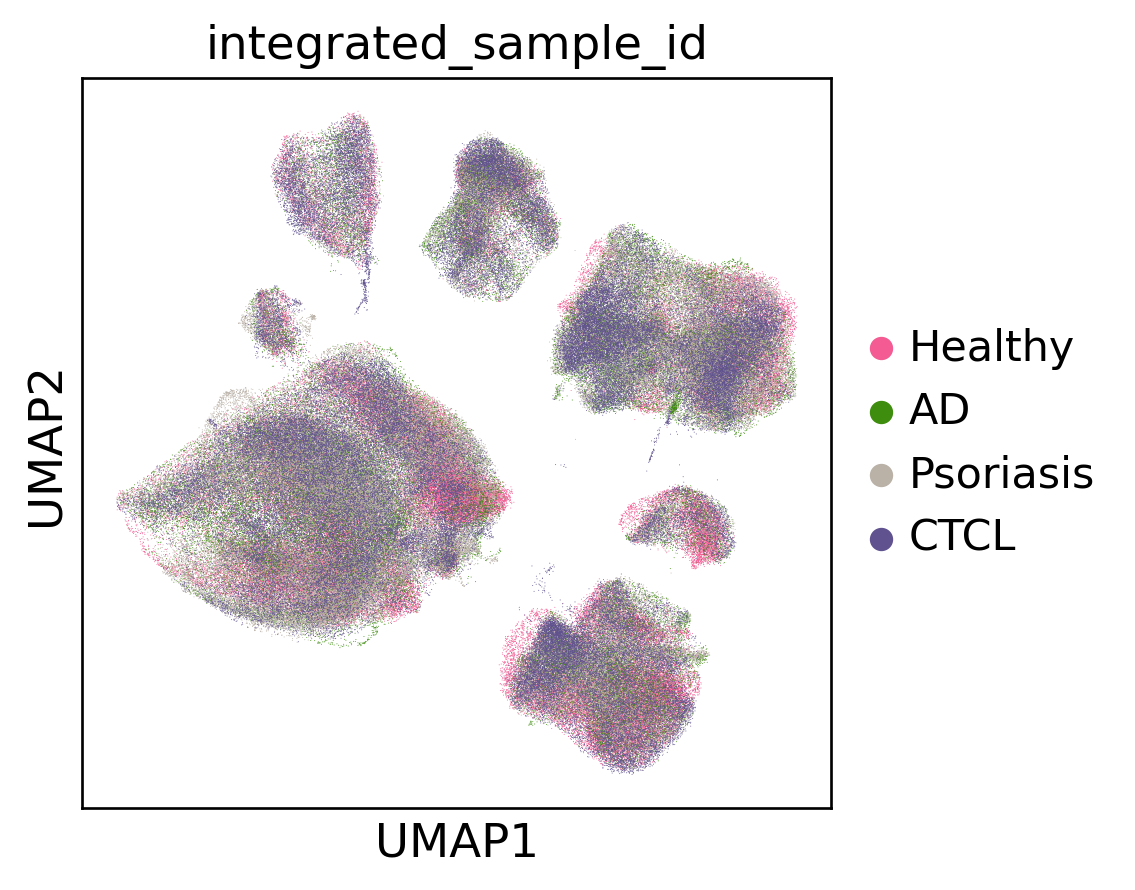

In [24]:
col = ['#F35B92','#3E8D0E','#BAB1A7','#60528F',
 '#75CFC1','#BFD03F','#7982E3','#C2501E','#EC6CDD',
 '#BFA829','#794FE0','#A1208F']
sc.settings.set_figure_params(dpi=120, facecolor='white')
sc.pl.umap(adata_filtered_harmony_sub, color=['integrated_sample_id'], palette = col)

In [27]:
def generate_colors(col_required):
    import random
    number_of_colors = col_required
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    return list(color)

#col = generate_colors(len(adata_filtered_harmony.obs["annotation"].unique()))
col = generate_colors(16)
col

['#3B5E83',
 '#FCC26F',
 '#BCD5C6',
 '#AB1A5B',
 '#41A261',
 '#9D3E35',
 '#EC060E',
 '#8B06ED',
 '#5D076B',
 '#8C3FF9',
 '#070EEC',
 '#3364A8',
 '#0AF133',
 '#855B38',
 '#365D9C',
 '#8D29B7']

In [4]:
col_record = ['#3B5E83',
 '#FCC26F',
 '#BCD5C6',
 '#AB1A5B',
 '#41A261',
 '#9D3E35',
 '#EC060E',
 '#8B06ED',
 '#5D076B',
 '#8C3FF9',
 '#070EEC',
 '#3364A8',
 '#0AF133',
 '#855B38',
 '#365D9C',
 '#8D29B7']

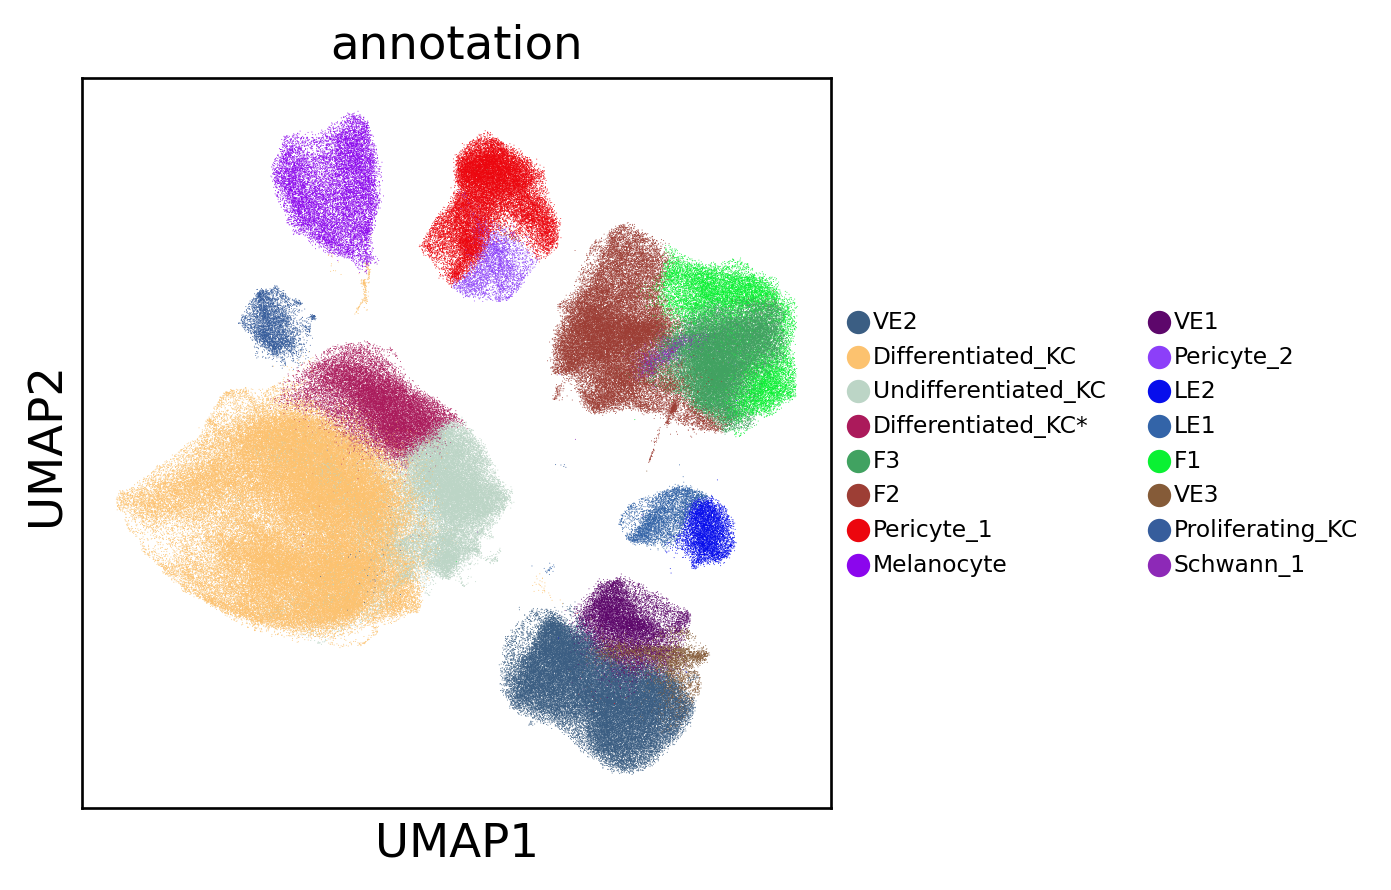

In [5]:
sc.settings.set_figure_params(dpi=120, facecolor='white')
sc.pl.umap(adata_filtered_harmony_sub, color=['annotation'], legend_fontsize=7, palette = col_record)

In [30]:
col

['#3B5E83',
 '#FCC26F',
 '#BCD5C6',
 '#AB1A5B',
 '#41A261',
 '#9D3E35',
 '#EC060E',
 '#8B06ED',
 '#5D076B',
 '#8C3FF9',
 '#070EEC',
 '#3364A8',
 '#0AF133',
 '#855B38',
 '#365D9C',
 '#8D29B7']

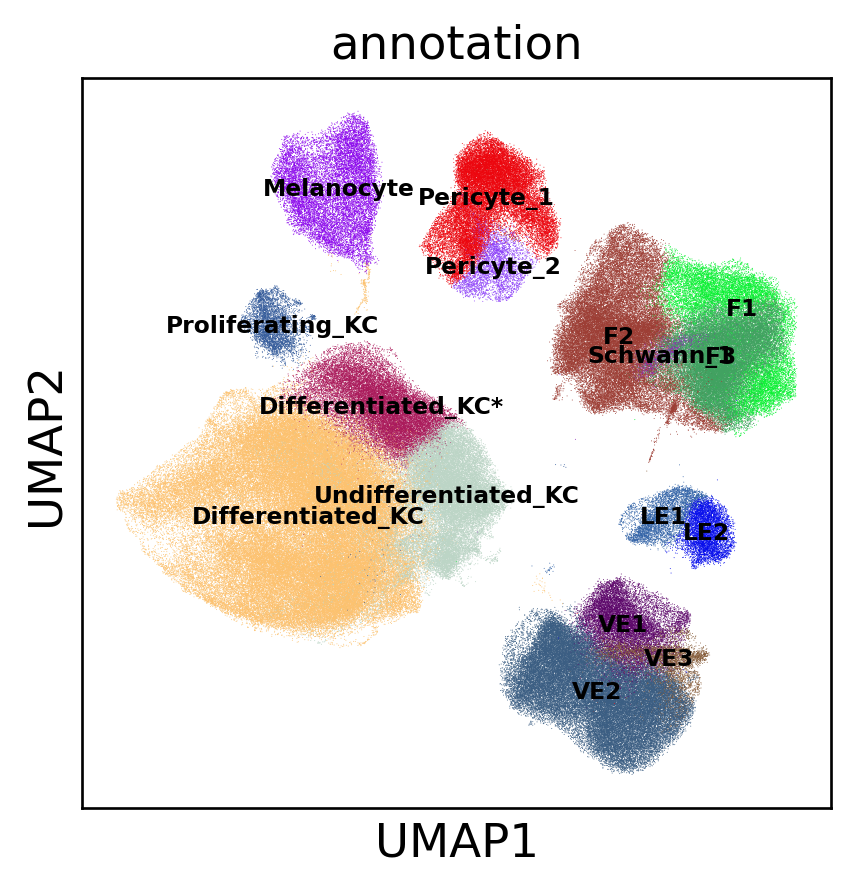

In [7]:
sc.settings.set_figure_params(dpi=120, facecolor='white')
sc.pl.umap(adata_filtered_harmony_sub, color=['annotation'], legend_loc='on data', legend_fontsize=7, palette = col_record)

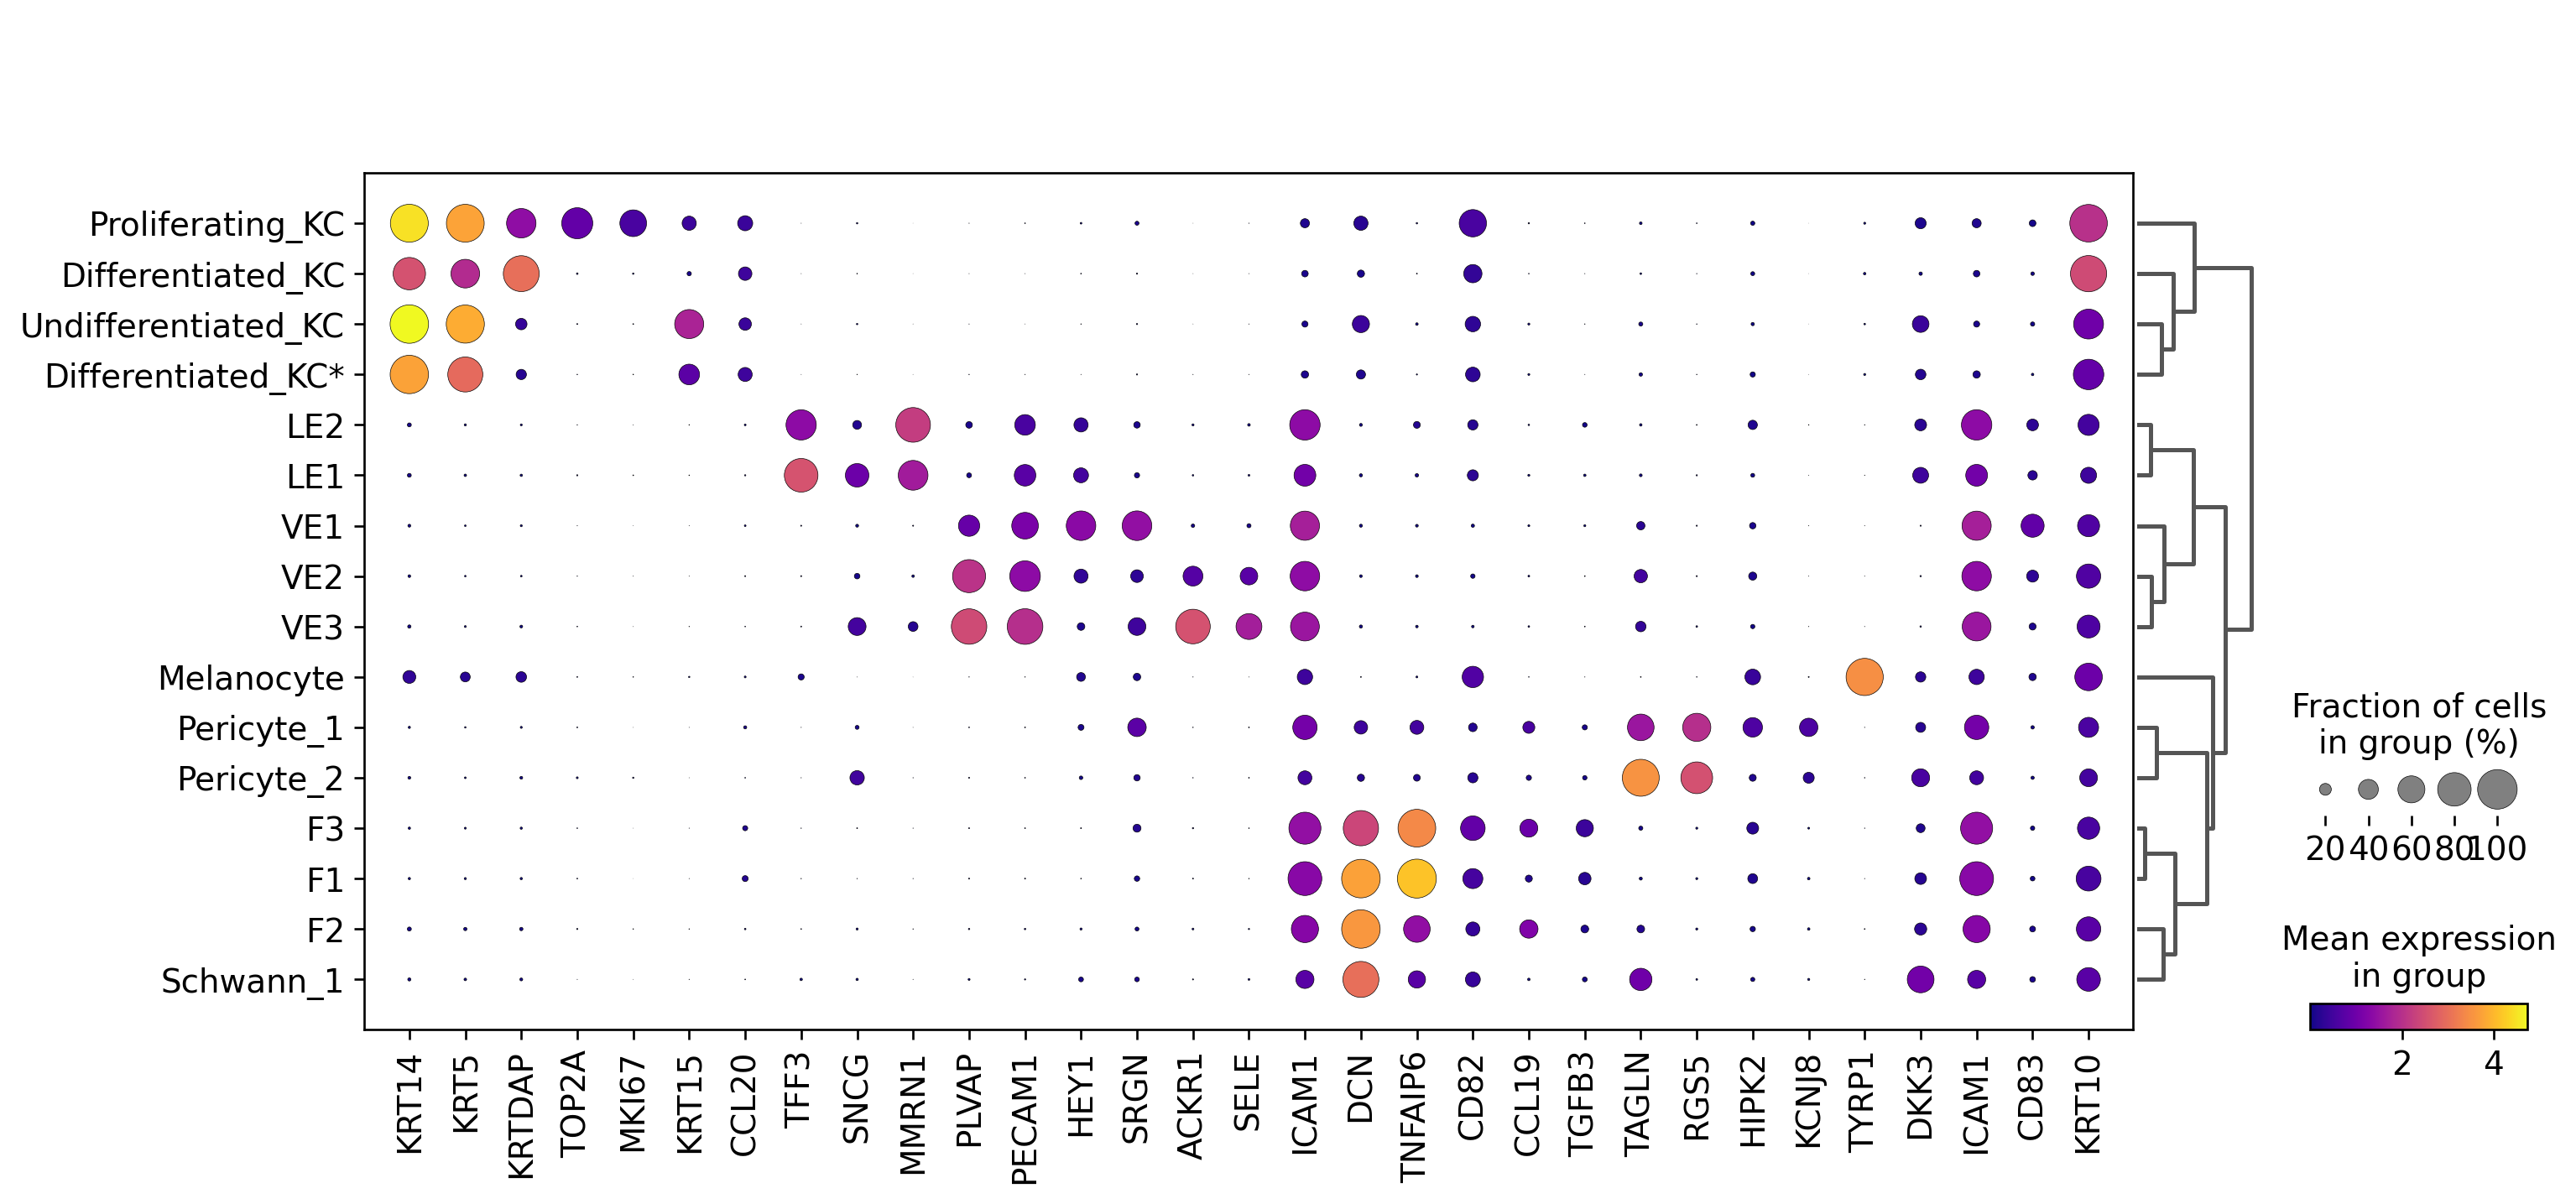

In [48]:
genes = ['KRT14','KRT5','KRTDAP','TOP2A','MKI67','KRT15','CCL20','TFF3','SNCG','MMRN1','PLVAP','PECAM1',
           'HEY1','SRGN','ACKR1','SELE','ICAM1',
          'DCN','TNFAIP6','CD82','CCL19','TGFB3','TAGLN','RGS5','HIPK2','KCNJ8','TYRP1','DKK3','ICAM1','CD83','KRT10']
sc.settings.set_figure_params(dpi=120)
dp = sc.pl.dotplot(adata_filtered_harmony_sub, genes, groupby='annotation',dendrogram=True, use_raw=True, color_map='plasma')

#### Abundance & Condition comparasion

In [26]:
adata_filtered_harmony_sub.obs['Site'][pd.isna(adata_filtered_harmony_sub.obs['Site'])] = 'lesion'

In [27]:
Site_condition = [i + '_' +j for i, j in zip(list(adata_filtered_harmony_sub.obs['integrated_sample_id']), list(adata_filtered_harmony_sub.obs['Site']))]
adata_filtered_harmony_sub.obs['Site_condition'] = Site_condition

In [28]:
adata_filtered_harmony_sub.obs['Site_condition']

AAACCTGAGAGTGACC-1-SKN8104894-Healthy    Healthy_non_lesion
AAACCTGAGGTCGGAT-1-SKN8104894-Healthy    Healthy_non_lesion
AAACCTGAGTCGAGTG-1-SKN8104894-Healthy    Healthy_non_lesion
AAACCTGCATACTCTT-1-SKN8104894-Healthy    Healthy_non_lesion
AAACCTGGTGGACGAT-1-SKN8104894-Healthy    Healthy_non_lesion
                                                ...        
GCCAAATAGTAGCGGT-1-40-CTCL                      CTCL_lesion
GCGCAACAGCCCTAAT-1-40-CTCL                      CTCL_lesion
GTCGTAAAGAGACGAA-1-40-CTCL                      CTCL_lesion
TAAGCGTTCTGTTGAG-1-40-CTCL                      CTCL_lesion
TCAGCTCAGCAATCTC-1-40-CTCL                      CTCL_lesion
Name: Site_condition, Length: 371401, dtype: object

In [29]:
adata_filtered_harmony_sub = adata_filtered_harmony_sub[adata_filtered_harmony_sub.obs['Site_condition'].isin(['Healthy_non_lesion', 
                                                                                                       'CTCL_lesion','AD_lesion','Psoriasis_lesion'])]

In [10]:
Mela = adata_filtered_harmony_sub[adata_filtered_harmony_sub.obs['annotation'].isin(['Melanocyte'])]

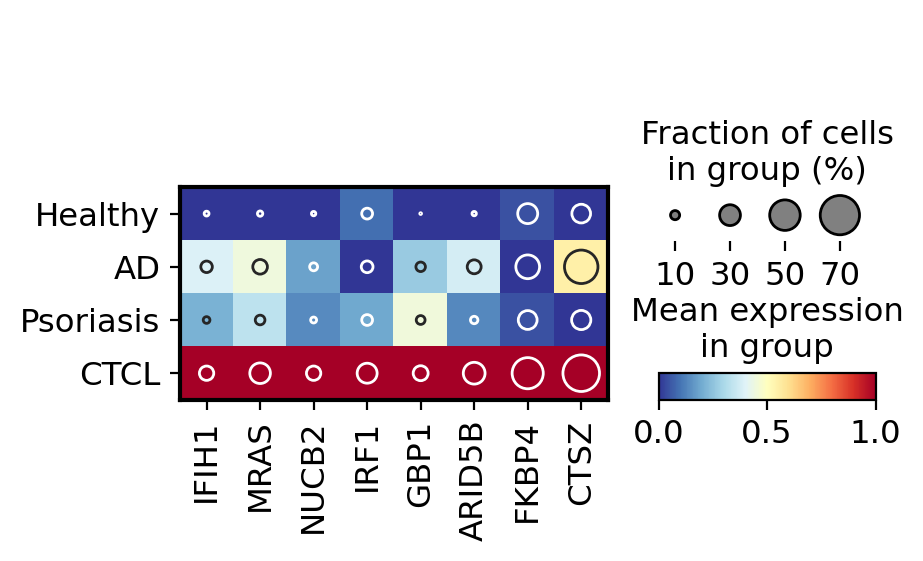

In [21]:
sc.settings.set_figure_params(dpi=100)
genes = ['IFIH1','MRAS','NUCB2','IRF1','GBP1','ARID5B','FKBP4','CTSZ']
dp = sc.pl.dotplot(Mela, var_names=genes, groupby='integrated_sample_id',dendrogram=False,
                   standard_scale='var',use_raw=True,var_group_rotation=0,swap_axes=False,return_fig=True)
dp.style(cmap='RdYlBu_r',color_on='square',dot_edge_color=None,dot_edge_lw=1)
dp.savefig('/home/jovyan/farm/CTCL/script_notebook/figures/DEGs_Melano.pdf')

In [34]:
KC = adata_filtered_harmony_sub[adata_filtered_harmony_sub.obs['annotation'].isin(['Differentiated_KC', 'Undifferentiated_KC',
                                                                                   'Differentiated_KC*', 'Proliferating_KC'])]

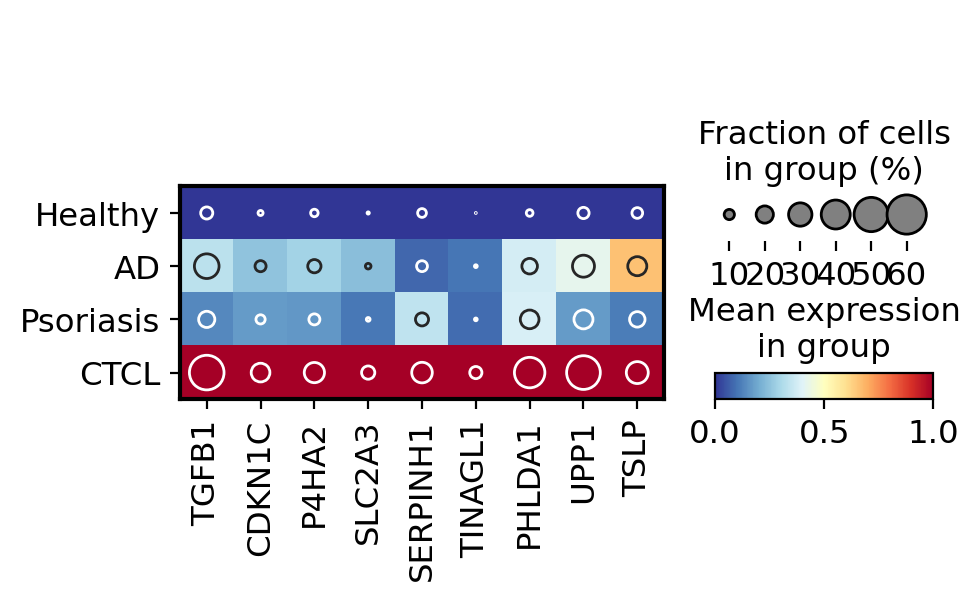

In [36]:
genes = ['TGFB1','CDKN1C','P4HA2','SLC2A3','SERPINH1','TINAGL1','PHLDA1','UPP1','TSLP']
dp = sc.pl.dotplot(KC, var_names=genes, groupby='integrated_sample_id',dendrogram=False,
                   standard_scale='var',use_raw=True,var_group_rotation=0,swap_axes=False,return_fig=True)
dp.style(cmap='RdYlBu_r',color_on='square',dot_edge_color=None,dot_edge_lw=1)
dp.savefig('/home/jovyan/farm/CTCL/script_notebook/figures/DEGs_KC.pdf')

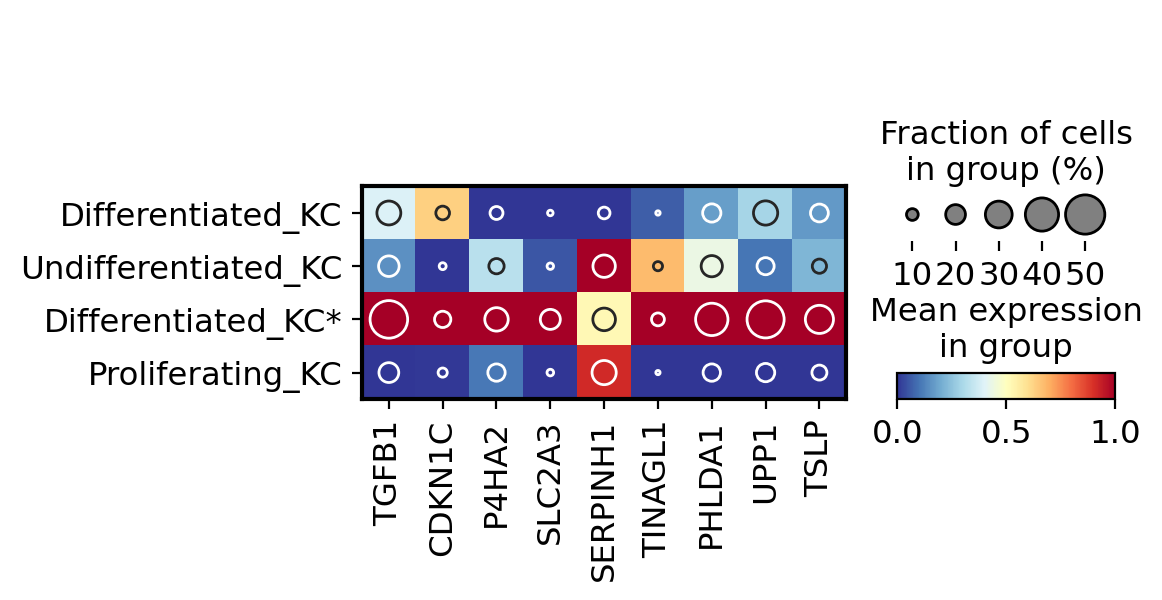

In [37]:
dp = sc.pl.dotplot(KC, var_names=genes, groupby='annotation',dendrogram=False,
                   standard_scale='var',use_raw=True,var_group_rotation=0,swap_axes=False,return_fig=True)
dp.style(cmap='RdYlBu_r',color_on='square',dot_edge_color=None,dot_edge_lw=1)
dp.savefig('/home/jovyan/farm/CTCL/script_notebook/figures/DEGs_KC_anno.pdf')

In [30]:
Fibro = adata_filtered_harmony_sub[adata_filtered_harmony_sub.obs['annotation'].isin(['F1', 'F2', 'F3'])]
#Fibro = adata_filtered_harmony_sub[adata_filtered_harmony_sub.obs['annotation'].isin(['F2'])]

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Site_condition' as categorical


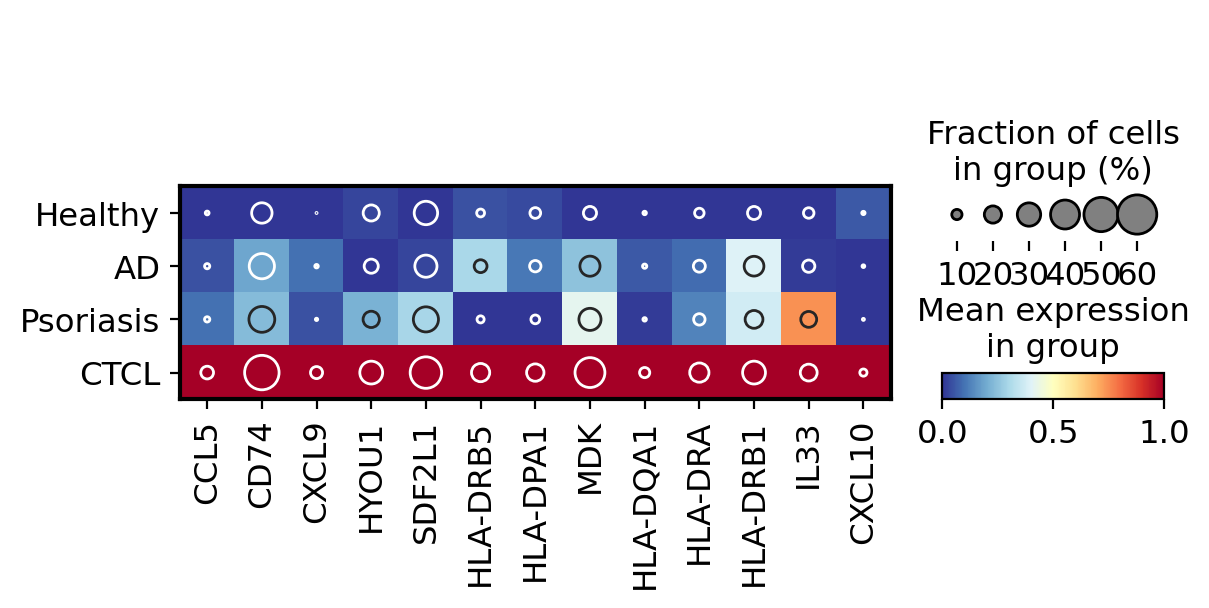

In [31]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
genes = ['CCL5','CD74','CXCL9','HYOU1','SDF2L1','HLA-DRB5','HLA-DPA1','MDK','HLA-DQA1','HLA-DRA','HLA-DRB1','IL33','CXCL10']
dp = sc.pl.dotplot(Fibro, var_names=genes, groupby='integrated_sample_id',dendrogram=False,
                   standard_scale='var',use_raw=True,var_group_rotation=0,swap_axes=False,return_fig=True)
dp.style(cmap='RdYlBu_r',color_on='square',dot_edge_color=None,dot_edge_lw=1).show()

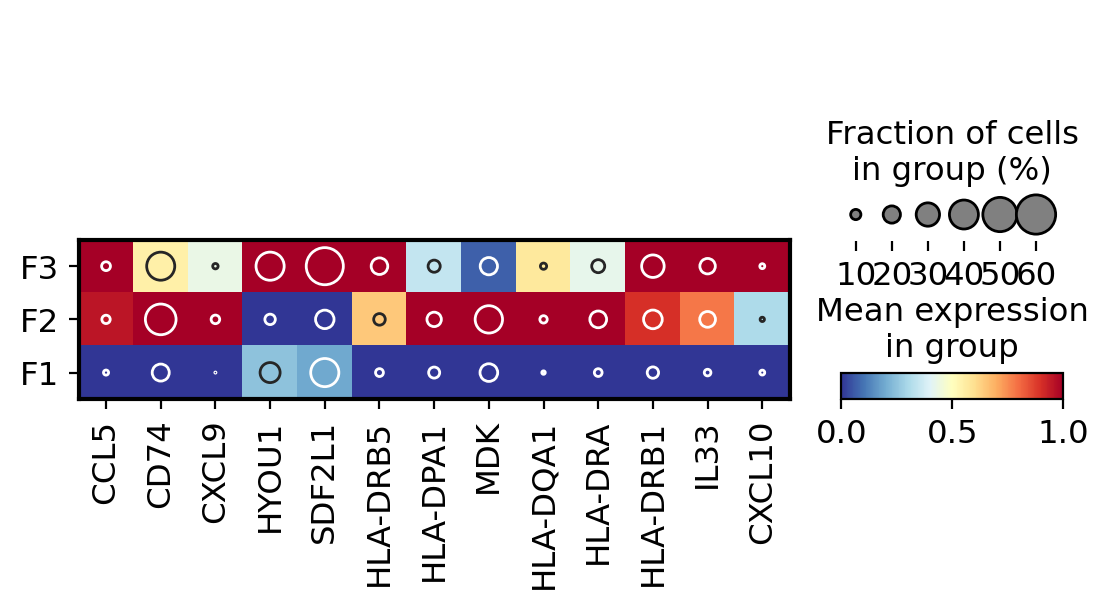

In [32]:
dp = sc.pl.dotplot(Fibro, var_names=genes, groupby='annotation',dendrogram=False,
                   standard_scale='var',use_raw=True,var_group_rotation=0,swap_axes=False,return_fig=True)
dp.style(cmap='RdYlBu_r',color_on='square',dot_edge_color=None,dot_edge_lw=1).show()

In [33]:
VE = adata_filtered_harmony_sub[adata_filtered_harmony_sub.obs['annotation'].isin(['VE1','VE2','VE3'])]

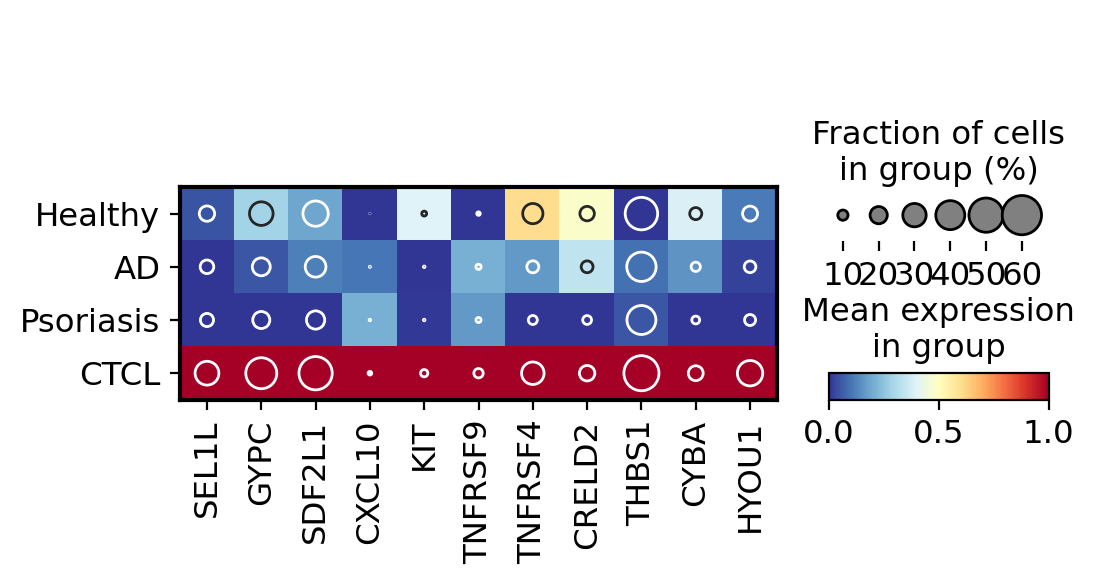

In [28]:
genes = ['SEL1L','GYPC','SDF2L1','CXCL10','KIT','TNFRSF9','TNFRSF4','CRELD2','THBS1','CYBA','HYOU1']
#genes = ['CXCL12','CD34','ICAM1']
dp = sc.pl.dotplot(VE, var_names=genes, groupby='integrated_sample_id',dendrogram=False,
                   standard_scale='var',use_raw=True,var_group_rotation=0,swap_axes=False,return_fig=True)
dp.style(cmap='RdYlBu_r',color_on='square',dot_edge_color=None,dot_edge_lw=1)
dp.savefig('/home/jovyan/farm/CTCL/script_notebook/figures/DEGs_VE.pdf')

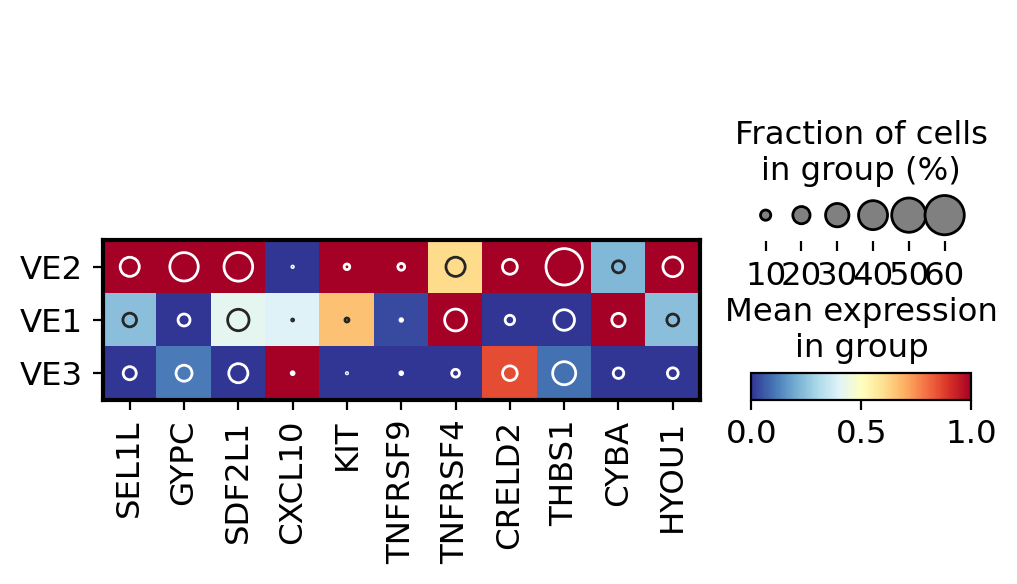

In [29]:
sc.settings.set_figure_params(dpi=100)
genes = ['SEL1L','GYPC','SDF2L1','CXCL10','KIT','TNFRSF9','TNFRSF4','CRELD2','THBS1','CYBA','HYOU1']
dp = sc.pl.dotplot(VE, var_names=genes, groupby='annotation',dendrogram=False,
                   standard_scale='var',use_raw=True,var_group_rotation=0,swap_axes=False,return_fig=True)
dp.style(cmap='RdYlBu_r',color_on='square',dot_edge_color=None,dot_edge_lw=1)
dp.savefig('/home/jovyan/farm/CTCL/script_notebook/figures/DEGs_VE_anno.pdf')